![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)

# <h1><center>Tutorial  <a href="https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/tutorial.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

This notebook provides an introductory tutorial for [**MuJoCo** physics](https://github.com/google-deepmind/mujoco#readme), using the native Python bindings.

<!-- Copyright 2021 DeepMind Technologies Limited

     Licensed under the Apache License, Version 2.0 (the "License");
     you may not use this file except in compliance with the License.
     You may obtain a copy of the License at

         http://www.apache.org/licenses/LICENSE-2.0

     Unless required by applicable law or agreed to in writing, software
     distributed under the License is distributed on an "AS IS" BASIS,
     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
     See the License for the specific language governing permissions and
     limitations under the License.
-->

# All imports

In [29]:
%load_ext autoreload
%autoreload 2

# Set up GPU rendering.
import distutils.util
import os
import subprocess
# # if subprocess.run('nvidia-smi').returncode:
# #   raise RuntimeError(
# #       'Cannot communicate with GPU. '
# #       'Make sure you are using a GPU Colab runtime. '
# #       'Go to the Runtime menu and select Choose runtime type.')

# # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# # This is usually installed as part of an Nvidia driver package, but the Colab
# # kernel doesn't install its driver via APT, and as a result the ICD is missing.
# # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
# NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
# if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
#   with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
#     f.write("""{
#     "file_format_version" : "1.0.0",
#     "ICD" : {
#         "library_path" : "libEGL_nvidia.so.0"
#     }
# }
# """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
  import mujoco.viewer # Also have to import this to trigger the installation of the viewer.
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np
from scipy.spatial.transform import Rotation as Robj
from scipy.optimize import curve_fit, fsolve
from helper_fns import *
from render_opts import *
import robot_controller
import model_selection

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)
# Set matplotlib font size
fonts = {'size' : 20}
plt.rc('font', **fonts)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


# Functions

In [30]:
## Helper function to align y-axis limits of multiple axes to zero
def align_zeros(axes):
    ylims_current = {}   #  Current ylims
    ylims_mod     = {}   #  Modified ylims
    deltas        = {}   #  ymax - ymin for ylims_current
    ratios        = {}   #  ratio of the zero point within deltas

    for ax in axes:
        ylims_current[ax] = list(ax.get_ylim())
                        # Need to convert a tuple to a list to manipulate elements.
        deltas[ax]        = ylims_current[ax][1] - ylims_current[ax][0]
        ratios[ax]        = -ylims_current[ax][0]/deltas[ax]
    
    for ax in axes:      # Loop through all axes to ensure each ax fits in others.
        ylims_mod[ax]     = [np.nan,np.nan]   # Construct a blank list
        ylims_mod[ax][1]  = max(deltas[ax] * (1-np.array(list(ratios.values()))))
                        # Choose the max value among (delta for ax)*(1-ratios),
                        # and apply it to ymax for ax
        ylims_mod[ax][0]  = min(-deltas[ax] * np.array(list(ratios.values())))
                        # Do the same for ymin
        ax.set_ylim(tuple(ylims_mod[ax]))


## Nonlinear cosine fitting function
def nl_cos_fit(x, y, extend_factor=2, maxfev=10_000):
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()

    if x.shape != y.shape:
        print(f"x.shape: {x.shape}, y.shape: {y.shape}")
        raise ValueError("x and y must have the same shape.")
    N = len(x)
    dx = x[1] - x[0]  # Assume uniform spacing

    # 1) Define basic cos model with parameters to fit
    def cos_model(x, amp, omega, phi, offset):
        return amp * np.cos(omega * x + phi) + offset

    # 2) Initial guesses (nonlinear solvers need decent starting point)
    offset0 = np.mean(y)                    # init offset (vertical shift) -> data mean
    amp0 = (np.max(y) - np.min(y)) / 2      # init amplitude (peak2peak height) -> half the range
    phi0 = 0.0                              # init phase shift -> start cos at 0.0 (normal cos fn)

    # estimate omega from the FFT peak
    y0 = y - offset0                        # zero-centered (subtract offset so the zero-frequency component doesn't dominate)
    fft = np.fft.rfft(y0)                   # positive-frequency spectrum
    freq = np.fft.rfftfreq(len(x), d=1.0)   # tells each index's corresponding frequency in cycles per sample
    # ignore the zero-freq bin when finding the peak
    peak = np.argmax(np.abs(fft[1:])) + 1   # +1 because we ignored the zero-frequency bin
    omega0 = 2*np.pi*freq[peak]             # convert cycles/sample -> rad/sample

    # Initial guess parameter array
    p0 = [amp0, omega0, phi0, offset0]

    lower = [0.0, 0.0, -np.pi, -1.0] #-np.inf]
    upper = [np.inf, np.pi, np.pi, 1.0] #np.inf]

    ## Nonlinear least squares (!!__ THIS IS ACTUALLY LEVENBERG-MARQUARDT __!!) minimizes sum of sq errors
    # 3) Fit
    popt, _ = curve_fit(
        cos_model, x, y,
        p0=p0, bounds=(lower, upper),
        maxfev=maxfev)                          # popt is the optimal parameters. pcov is the covariance (diagonal is uncertainty of each parameter)
    
    # 4) Build extended x_out
    N_out = extend_factor * N
    x_start = x[0]
    x_out = x_start + np.arange(N_out) * dx

    y_out = cos_model(x_out, *popt)

    # Build fitted curve
    return x_out, y_out


## Let's also do a polynomial fit for comparison
def poly_fit(x, y, maxdeg=3, extend_factor=2):
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()

    if x.shape != y.shape:
        print(f"x.shape: {x.shape}, y.shape: {y.shape}")
        raise ValueError("x and y must have the same shape.")
    N = len(x)
    dx = x[1] - x[0]  # Assume uniform spacing

    # 1) Fit polynomial of degree maxdeg
    coeffs = np.polyfit(x, y, maxdeg)

    # 2) Build extended x_out
    N_out = extend_factor * N
    x_start = x[0]
    x_out = x_start + np.arange(N_out) * dx

    y_out = np.polyval(coeffs, x_out)

    return x_out, y_out


## Linear fit
def linear_fit(x, y, extend_factor=2):
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()

    if x.shape != y.shape:
        print(f"x.shape: {x.shape}, y.shape: {y.shape}")
        raise ValueError("x and y must have the same shape.")
    N = len(x)
    dx = x[1] - x[0]  # Assume uniform spacing

    # 1) Fit linear model
    coeffs = np.polyfit(x, y, 1)

    # 2) Build extended x_out
    N_out = extend_factor * N
    x_start = x[0]
    x_out = x_start + np.arange(N_out) * dx

    y_out = np.polyval(coeffs, x_out)

    return x_out, y_out


# Helper fn to shift pitch data to remove initial 'ramp up' of force
def shift_pitch_data(pitch_full, f_full):
    """
    Shift the pitch data to remove the initial 'ramp up' of force.
    This is done by finding the index of the maximum force and shifting the pitch data accordingly.
    """
    inflection_idx = np.argmax(f_full)
    n_copy = len(f_full) - inflection_idx
    temp_pitch = np.zeros_like(pitch_full)
    if n_copy > 0:
        temp_pitch[inflection_idx : inflection_idx + n_copy] = pitch_full[0 : n_copy]

    return temp_pitch.copy()  # Copy the shifted pitch data

# Fit a model to the data
def fit_model(f_full, pitch_full, t_full, theta_safe=np.inf, extend_factor=1.0, plot=True):
    
    f_full = np.linalg.norm(f_full, axis=1)     # Get the norm of the force vector

    # Mujoco oddly shows initially increasing force as two come in contact.
    # Let's shift the pitch data to remove the initial 'ramp up' of force, at f_max
    pitch_full = shift_pitch_data(pitch_full, f_full)

    t_rem = np.array([])
    f_rem = np.array([])
    pitch_rem = np.array([])
    
    t_sample = t_full
    f_sample = f_full
    pitch_sample = pitch_full

    zero_crossing_time = t_full[-1]
    topple_angle_est = pitch_full[-1]

    # ============================================================
    # If max_tip_angle specified, sample the data up to that angle
    # ============================================================
    if theta_safe != np.inf:
        # Find indexes where pitch is below theta_safe
        sample_idxs = np.where(np.abs(pitch_full) <= theta_safe)[0]
        # Also remove outliers before inflection_idx
        # sample_idxs = sample_idxs[sample_idxs > inflection_idx]  # Only keep indices

        # Now get the force, time, and pitch data up to that index
        f_sample = f_full[sample_idxs]
        t_sample = t_full[sample_idxs]
        pitch_sample = pitch_full[sample_idxs]


        ## FIRST TRY USING BASIC METHOD TO JUST GET F=0 IDX AND CORRESPONDING ANGLE

        force_coeffs = np.polyfit(t_sample, f_sample, deg=2)
        fitted_force_fn = np.poly1d(force_coeffs) # Create poly fn to evaluate force at any time

        # Define (python) function for fsolve
        def func_force(t):
            return fitted_force_fn(t)

        # Use fsolve to find the time when force is zero
        zero_crossing_time, = fsolve(func_force, t_sample[-1]*1.25) # Use initial guess just after last sampled t

        print(f"Zero crossing time: {zero_crossing_time:.3f} s")

        # Also extrapolate the pitch at that time
        pitch_coeffs = np.polyfit(t_sample, pitch_sample, deg=2)
        fitted_pitch_fn = np.poly1d(pitch_coeffs) # Create poly fn to evaluate pitch at any time
        topple_angle_est = fitted_pitch_fn(zero_crossing_time)
        print(f"Estimated topple angle at zero force crossing: {np.rad2deg(topple_angle_est):.3f} degrees")

        # Calculate the remaining time, force, and pitch data
        t_rem = np.linspace(t_sample[-1], zero_crossing_time, 100)
        f_rem = fitted_force_fn(t_rem)  # Fit the remaining force data using the fitted force function
        pitch_rem = fitted_pitch_fn(t_rem)  # Fit the remaining pitch data using the fitted pitch function

    # ===========================================================

    # 2) Let's fit using three different methods: nonlinear cosine fit , polynomial fit , and linear fit
    if plot:
        fig, ax1 = plt.subplots(figsize=(9, 6))
        ax2 = plt.twinx()

        ax1.axhline(0, color='c', label='_') # Horizontal line at zero for reference

        # 3) Plot the sampled force data
        ax1.plot(t_sample, f_sample, color='b', linewidth=2, label='Push force (norm)')

        if len(t_rem) > 0:
            # Plot the extrapolated part
            ax1.plot(t_rem, f_rem, color='b', linestyle='--', label='_')

        # Plot the zero crossing point if applicable
        ax1.plot(zero_crossing_time, 0, 'kx', markersize=10, label='_')
        ax2.plot(zero_crossing_time, np.rad2deg(topple_angle_est), 'gx', markersize=10, label='_')

        ax1.set_xlabel("Time (s)", fontsize=20)
        ax1.set_ylabel("Force Norm (N)", color='b', fontsize=20)
        ax1.tick_params(axis='y', labelcolor='b')
        ax1.set_ylim(-0.1, 1.1 * np.max(f_full))
        ax1.set_xlim(0.9 * t_full[0], 1.1 * t_rem[-1] if len(t_rem) > 0 else 1.1 * t_full[-1])  # Set x-limits to the full range of times

        # 4) Plot the sampled payload pitch on ax2
        ax2.plot(t_sample, np.rad2deg(pitch_sample), color='g', linestyle='-', label='Payload pitch')      # Plot the payload tilt (pitch) angle
        ax2.plot(t_rem, np.rad2deg(pitch_rem), color='g', linestyle='--', label='_')
        ax2.tick_params(axis='y', labelcolor='g')
        ax2.set_ylabel("Payload Pitch (degrees)", color='g', fontsize=20)       # Add a second y-axis for the tilt angle
        ax2.set_ylim(-5, 30) # max hardcoded for now, can change to 1.1*max_pitch later
        
        align_zeros([ax1, ax2])  # Align the y-axes to zero

        # 4) Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=20)

        plt.title(r"Force & Pitch vs Time for $\theta_{safe}$ = %.f$^\circ$" %np.rad2deg(theta_safe), fontsize=20)
        plt.show()

    # print(zero_crossing_time, topple_angle_est)
    return zero_crossing_time, topple_angle_est


# Get the line-of-action passing thru CoM of generalized plane
def get_com(max_tip_angle, f, times, pitch, irb_controller, plot=True):
    """
    Estimate the center of mass (CoM) of the payload using the force, time, and pitch data.
    Instead of re-doing simulation, sample the data up to a maximum tip angle.
        max_tip_angle: Maximum tip angle in degrees to consider for the CoM estimation.
    """
    idx_sample = np.where(np.abs(pitch) <= np.deg2rad(max_tip_angle))[0]
    # Now get the force, time, and pitch data up to that index
    f_sample = np.linalg.norm(f, axis=1)[idx_sample]
    t_sample = times[idx_sample]
    pitch_sample = pitch[idx_sample]


    # ## Now let's estimate the CoM using sampled data.
    # # Recall the moment-balance equation for the payload:
    # # ΣM = 0 --> F * h_f = mg * (x_c * cos(pitch) - y_c * sin(pitch))
    # # Given that origin is taken at tipping/pivot edge

    # # Rearrange and convert to matrix form given N samples:
    # # F = A @ β, where A is [cos , -sin] matrix of shape (N, 2) and 
    # # β is [x_c; y_c] vector of shape (2,) scaled by the constant (mg/h_f)

    # # Create A = [-cos, -sin] matrix of pitch samples of shape (N, 2)
    # # Note: normally this would be [cos, -sin], but we take the origin at the pivot edge with x AWAY from rectangle
    # A = np.array([-np.cos(pitch_sample), -np.sin(pitch_sample)]).T

    # # Least-squares to find x vector (can also do np.linalg.lstsq)
    # beta = np.linalg.inv(A.T @ A) @ A.T @ f_sample        # Recall (A.T @ A)^-1 @A is the moore-Penrose pseudo-inverse
    # print(f"\nCoM lies on the line defined by: x_hat = {beta[0]:.3f}, y_hat = {beta[1]:.3f}")

    # # Calculate the height of the applied force on the payload WRT payload's frame (tipping edge)
    # # Height is (global) EE z-position minus the table surface (aka payload bottom) z-position
    # _, p_ee = TransToRp(irb_controller.FK())
    # h_f_global = p_ee[2]  # Global EE z-position
    # surface_height = irb_controller.get_surface_pos()[2]        # Table surface z-position
    # print(f"Surface_height: {surface_height:.2f} m, EE height: {h_f_global:.2f} m")
    # # payload_bottom = payload_pos - surface_ht                      # Table surface is 0.1 m, so bottom is at payload center z-position minus 0.1
    # h_f = h_f_global - surface_height                       # Height of applied force on the payload
    # m = 0.1 # Mass of the payload
    # g = 9.81 # Gravity
    # print(f"with h_f={h_f:.2f}, m={m}, g=9.81.")

    # x_c = beta[0] * h_f / (m * g)
    # y_c = beta[1] * h_f / (m * g)
    # print(f"Estimated CoM: x_c = {x_c:.3f}, y_c = {y_c:.3f}\n\n")

    # topple_angle_est = np.arctan2(x_c, y_c)  # atan2(y, x) gives the angle in radians
    # print(f"Estimated Toppling angle (manual LS): {np.rad2deg(topple_angle_est):.3f} degrees")


    ## NOW QUICKLY TRY USING BASIC METHOD TO JUST GET F=0 IDX AND CORRESPONDING ANGLE
    force_coeffs = np.polyfit(t_sample, f_sample, 1) # Linear at first
    fitted_force_fn = np.poly1d(force_coeffs) # Create poly fn to evaluate force at any time
    print(f"Fitted force fn: {fitted_force_fn}")

    # Find zero crossing of f
    initial_guess = t_sample[-1] * 1.1 # Start looking for zero crossing at the end of the data

    # Define (python) function for fsolve
    def func_force(t):
        return fitted_force_fn(t)

    # Use fsolve to find the time when force is zero
    from scipy.optimize import fsolve
    zero_crossing_time, = fsolve(func_force, initial_guess)

    print(f"Zero crossing time: {zero_crossing_time:.3f} s")

    # Also extrapolate the pitch at that time
    pitch_coeffs = np.polyfit(t_sample, pitch_sample, 1) # Linear at first
    fitted_pitch_fn = np.poly1d(pitch_coeffs) # Create poly fn to evaluate pitch at any time
    topple_angle_est = fitted_pitch_fn(zero_crossing_time)
    print(f"Estimated topple angle at zero force crossing: {np.rad2deg(topple_angle_est):.3f} degrees")
    

    if plot:
        ## Plot the sampled data and the fitted curves
        fit_model(f_sample, pitch, times, plot=True, extend_factor=22/max_tip_angle, plot_cospoly=False) # For plotting, provide the entire pitch history

    return x_c, y_c, topple_angle_est


## Full simulation of toppling

In [63]:
## Let's recall the model to reset the simulation
model, data = model_selection.select_model('../assets/table_push.xml', 'box')

## Setup based on robot model
irb_controller = robot_controller.controller(model, data)

## We know the following pose is just in front of the payload
T_init = np.array([[    0.0,   0.0,     1.0,     0.93 ],
                    [   0.0,   1.0,     0.0,     0.0  ],
                    [  -1.0,   0.0,     0.0,     0.25 ],
                    [   0.0,   0.0,     0.0,     1.0  ]])

## Set the robot to the desired initial pose
q_init = irb_controller.IK(T_init, method=2, damping=0.5, max_iters=1000) # DLS method
irb_controller.set_pose(q_init)

## The pose we want to reach FOR POSITION CONTROL (format: 4x4 matrix)
T_des = T_init.copy()
T_des[0:3, 3] += np.array([0.15, 0.0, 0.0])  # Move EE forward by 0.5 m in x direction
q_final = irb_controller.IK(T_des)

# Get quintic polynomial coefficients for smooth trajectory
TRAJ_DURATION = 4.0 # sec
traj_coeffs = irb_controller.generate_quintic_trajectory(q_init, q_final, TRAJ_DURATION)

## Initialize time, force and tilt history for plotting
# data.time = 0.0
t_hist = np.empty((0,))
f_hist = np.zeros((0,3))
pitch_hist = np.empty((0,))

# Set the stop angle, for full sim this is when the payload topples over (i.e. pitch angle is 90 degrees)
STOP_ANGLE = np.deg2rad(90.0)

# Array of the tipping edge 'line segment'
# NOTE: code currently only allows for line-segment contacts aka two-point contacts, not single-point or multi-point.
tip_edge_pos = []

# --- Additions for video recording ---
frames = []
framerate = 30
duration = 10

## IMPORTANT: Set the rendering options
# Create MjvCamera and MjvOption objects and initialize with default values
cam_obj = mujoco.MjvCamera() # This will be our camera for rendering
opt_obj = mujoco.MjvOption() # This will be our visualization options
mujoco.mjv_defaultCamera(cam_obj)
mujoco.mjv_defaultOption(opt_obj)
set_render_opts_for_renderer(model, cam_obj, opt_obj)

# Create the renderer for video recording
renderer = mujoco.Renderer(model, height=720, width=1280)

# ===========================================================================
with mujoco.viewer.launch_passive(model, data, show_left_ui=False) as viewer:
    set_render_opts_for_viewer(model, viewer) # Set rendering options for the interactive viewer
    
    while viewer.is_running() and not irb_controller.stop and data.time < duration: # add a seconds for trajectory to settle
        
        ## Determine target joint position for the current time step
        q_desired = irb_controller.evaluate_trajectory(data.time, traj_coeffs, TRAJ_DURATION)

        ## Set joint position control
        irb_controller.set_position_control(q_desired)

        # Get payload pitch and check toppling stop condition
        tip_angle = irb_controller.get_payload_pose(output='pitch')

        if abs(tip_angle - np.deg2rad(90.0)) < 1e-3:    # ALWAYS check for pitch of 90 degrees (toppled) TODO: change pitch to primary tip axis
            print("Payload has tipped to threshold, stopping simulation.")
            irb_controller.stop = True

        # Get contact force(s) ONLY between EE and payload
        f_curr = irb_controller.get_pushing_force()

        # Initialize contact vertices list for this time step
        contact_vertices = []

        # 
        # Only append if contact is occurring with pusher and payload AND force is decreasing
        if np.linalg.norm(f_curr) > 0.0:
            # Append current force, pitch angle, and time to history
            f_hist = np.vstack((f_hist, f_curr))
            pitch_hist = np.append(pitch_hist, tip_angle)
            t_hist = np.append(t_hist, data.time)

            ## We would like to define a plane on which the CoM lies. A plane can be defined by two lines:
            # In this case, one line is the contact edge of payload and table, and the second line is the 
            # line-of-action of critical toppling angle. If so, get the two contact points of tipping edge
            for contact in irb_controller.data.contact:
                geom_names = [mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_GEOM, int(id)) for id in contact.geom]
                # If the contact is between the pusher and payload, skip it
                if 'push_rod' in geom_names:
                    continue
                else:
                    contact_vertices.append(contact.pos)
        
        # IFF there are exactly two contacts between the payload and table, we can define a line segment in the plane
        if len(contact_vertices) == 2:
            tip_edge_pos.append(np.array(contact_vertices).ravel())  # Append the contact vertices as a row vector

        # Step the simulation
        mujoco.mj_step(model, data)
        
        # Update the interactive viewer
        viewer.sync()

        # Add frame to the video recording
        if len(frames) < data.time * framerate:
            renderer.update_scene(data, camera=cam_obj, scene_option=opt_obj)  # Update the renderer with the current scene
            pixels = renderer.render()
            frames.append(pixels)  # Capture the current frame for video recording

renderer.close()  # Close the renderer after the simulation ends

Loading environment '../assets/table_push.xml' with object 'box'...
Model loaded successfully.
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)

IK converged in 11 iterations.
IK finished, robot state restored.
**********************************
(6, 6)
(6, 6)
(6, 6)

IK converged in 3 iterations.
IK finished, robot state restored.
**********************************

Generated a 4.00 sec trajectory to reach final pose.
Payload has tipped to threshold, stopping simulation.


In [57]:
media.show_video(frames, fps=60, loop=True)

## Fit an approximation to the full force data

Actual CoM Position in payload frame: [-0.04  0.04  0.1 ]


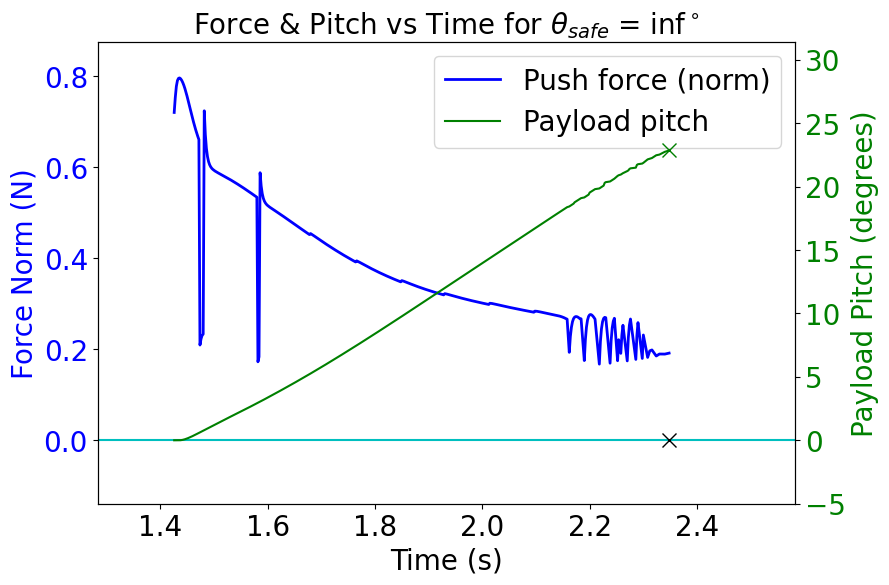


Zero-crossing time: 2.348 s

TOPPLING (CRITICAL) ANGLE: 22.84 degrees


Estimated CoM Method 1: [-0.04   0.04   0.095]


Estimated CoM Method 2: [-0.04   0.04   2.567]


Estimated CoM Method 3: [-0.04   0.04   0.095]



In [58]:
## Here's the actual CoM position in the payload frame
# We assume we have the x,y position from 2D com, but the z position is unknown.
c_proj = np.array([-0.04, 0.04, 0.1])
print(f"========\nActual CoM Position in payload frame: {c_proj}\n========")

t_ZMP, theta_crit = fit_model(f_hist, pitch_hist, t_hist, plot=True)
print(f"\nZero-crossing time: {t_ZMP:.3f} s")
print(f"\nTOPPLING (CRITICAL) ANGLE: {np.rad2deg(theta_crit):.2f} degrees\n")
# Actual toppling angle = 21.8 degrees (found thru: theta = atan(r_w/h_c))

## Get avg tip edge vertices
tip_edge_avg = np.mean(np.array(tip_edge_pos), axis=0)
p1 = tip_edge_avg[:3]  # First three elements are the first contact point
p2 = tip_edge_avg[3:]  # Last three elements are the second contact point

## ____ Three Ways to estimate CoM ____ ##

## 1) Using projection of 2D xy CoM onto the plane defined by the tip edge and the critical toppling angle
# The plane normal:
n = np.array([np.cos(theta_crit), 0, np.sin(theta_crit)]) # Found by 'rotating' the y-z plane by toppling angle

# The projection of CoM onto the above plane
cz = -(c_proj[0]*n[0] + c_proj[1]*n[1]) / n[2] # z-coordinate of the CoM projection onto the plane
c = np.array([c_proj[0], c_proj[1], cz])  # CoM projection onto the plane
print(f"\nEstimated CoM Method 1: {c}\n")


## 2) Using the critical toppling angle and the distance from CoM projection to tipping edge
# Define remaining vectors:
v_tip = p2 - p1  # Vector along the line segment (tipping edge)
w = c_proj - p1  # Vector from the first contact point to the CoM projection

# Euclidian (norm) distance from CoM_proj to tipping edge
d = np.linalg.norm(np.cross(v_tip, w)) / np.linalg.norm(v_tip)
x0 = c_proj[0]
y0 = c_proj[1]
x1 = p1[0]
x2 = p2[0]
y1 = p1[1]
y2 = p2[1]

# Calculate d more explicitly
d_alternate = np.abs((x2 - x1) * (y1 - y0) - (x1 - x0) * (y2 - y1)) / np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
# d should be around 0.04 m but is being calculated as 1.09


# quickly get the position of the box frame at site 'frame_site'
box_pos = irb_controller.get_payload_pose(site='frame_site')
# print(f"Box frame position: {box_pos}")
# Calculate the CoM height zc using critical toppling angle
zc = d / np.tan(theta_crit)
# And the final 3d CoM is:
com = np.array([c_proj[0], c_proj[1], zc])
print(f"\nEstimated CoM Method 2: {com}\n")


## 3) Use the scalar def and geometry and tan to find CoM
# first find r_c distance from tipping edge to CoM (radius of CoM rotation)
r_c = 0.04
h_c = r_c / np.tan(theta_crit)
# h_c = r_c / np.tan(np.deg2rad(21.8014))
print(f'\nEstimated CoM Method 3: {np.array([c_proj[0], c_proj[1], h_c])}\n')

### Also plot pitch vs force

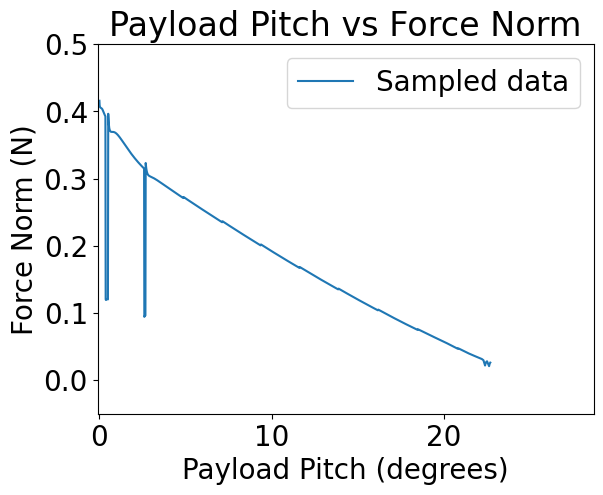

[0.416 0.412 0.409 ... 0.023 0.025 0.026]


In [28]:
f_hist_norm = np.linalg.norm(f_hist, axis=1)
pitch_hist_deg = shift_pitch_data(np.rad2deg(pitch_hist), f_hist_norm)
f_hist_norm = f_hist_norm[1:]  # Remove initial massive force
pitch_hist_deg = pitch_hist_deg[1:]  # Remove initial massive force

plt.plot(pitch_hist_deg, f_hist_norm, label='Sampled data')
plt.xlabel('Payload Pitch (degrees)')
plt.ylabel('Force Norm (N)')
plt.title('Payload Pitch vs Force Norm')
plt.ylim(-0.05, 0.5)
plt.xlim(-0.1, pitch_hist_deg.max() + 6)
plt.legend()
plt.show()

print(f_hist_norm)

### Now to do a small push and interpolate the force zero-crossing

Instead of re-simulating, take a subset of the full data

In [ ]:
# Let's choose a payload angle at which to 'sample' our data and find that index

# theta_safe = 6 # degrees
_, theta_crit = fit_model(f_hist, pitch_hist, t_hist, theta_safe=np.deg2rad(6), plot=True)
z_c = 0.04 / np.tan(theta_crit)  # Calculate the height of CoM using the critical angle
print(f"Estimated CoM height at theta_safe=6 degrees: {z_c:.3f} m\n\n")

# theta_safe = 12 # degrees
_, theta_crit = fit_model(f_hist, pitch_hist, t_hist, theta_safe=np.deg2rad(12), plot=True)
z_c = 0.04 / np.tan(theta_crit)  # Calculate the height of CoM using the critical angle
print(f"Estimated CoM height at theta_safe=12 degrees: {z_c:.3f} m\n\n")

# theta_safe = 18 # degrees
_, theta_crit = fit_model(f_hist, pitch_hist, t_hist, theta_safe=np.deg2rad(18), plot=True)
z_c = 0.04 / np.tan(theta_crit)  # Calculate the height of CoM using the critical angle
print(f"Estimated CoM height at theta_safe=18 degrees: {z_c:.3f} m\n\n")

### Some options and extensions:

Before pushing:
- Determine 'good' pushing face

Additional Parameters to Extract:
- Inertia matrix
- Mass
- Friction

During pushing:
- Stop tipping at 50% of initial pushing contact force

After pushing:
- Push along a trajectory

Separate extensions:
- Compare against adaptive control parameter adjustment
- Use LLM to determine good pushing face
- Train RL and generate 3D NONPREHENSILE data set